In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import monai
import nibabel as nib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from ACDCUNet import ACDCUNet, build_dict_images, LoadImageData

The following code blocks takes care of loading the image paths and labels

In [3]:
data_path = "ACDC/database"
test_dict_list = build_dict_images(data_path, mode='testing').ravel()

> Visualization  

The following code blocks are responsible for visualizing the images, the second one shows an animation of all slices.

7


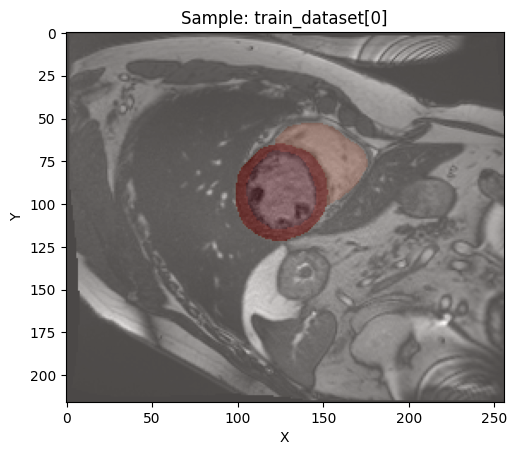

In [4]:
# Showing a single slice
def visualize_image_sample(sample, title=None):
    print(len(sample))
    image = np.squeeze(sample['image'])
    label = np.squeeze(sample['label'])
    slice_image = image[:, :]  # Access 'image' attribute of the 'sample' object
    slice_label = label[:, :]  # Access 'label' attribute of the 'sample' object
    plt.imshow(slice_image, cmap='gray')
    plt.imshow(slice_label, alpha=0.3, cmap='Reds')
    plt.xlabel('X')
    plt.ylabel('Y')
    if title is not None:
        plt.title(title)  # Set the title if provided
    plt.show()

visualize_image_sample(LoadImageData()(test_dict_list[0])[3], title='Sample: train_dataset[0]')

2023-07-06 14:15:46,342 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


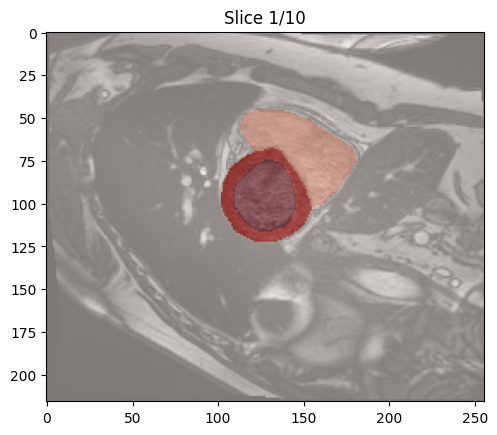

In [5]:
# Showing multiple slices
data = LoadImageData()(test_dict_list[0])

fig, ax = plt.subplots()

# Initialize an empty plot
plot = ax.imshow(data[0]["image"], cmap='gray')
plot2 = ax.imshow(data[0]["label"], alpha=.5, cmap='Reds')

# Function to update the plot for each frame
def update_frame(frame):
    plot.set_data(data[frame]["image"])
    plot2.set_data(data[frame]["label"])
    ax.set_title(f"Slice {frame+1}/{len(data)}")  # Update the title with the current slice number

# Create the animation
animation = FuncAnimation(fig, update_frame, frames=len(data), interval=200)

# Function to display the animation in the notebook
def display_animation(anim):
    # plt.close(anim._fig)
    return HTML(anim.to_jshtml())

# Display the animation
display(display_animation(animation))

> Transforms

The following code block contains the transform that is applied to the train images (random_transform) and the transform that is applied to the validation/test images (test_transform). It also creates cached datasets for the train and validation images.

In [6]:
# Create the composed transform
test_transform = monai.transforms.Compose([
        LoadImageData(),
        # monai.transforms.SqueezeDim(dim=0),
        monai.transforms.AddChanneld(keys=['label', 'image', 'left_ventricle', 'wall', 'right_ventricle']),
        monai.transforms.ResizeWithPadOrCropd(keys=['label', 'image',  'left_ventricle', 'wall', 'right_ventricle'], spatial_size=(256, 256))
])

/home/bart/projects_uni/2022-2b-dl-medical-new/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
post_label = monai.transforms.AsDiscrete(threshold=0.5)
sigmoid = torch.nn.Sigmoid()

acdc_unet = ACDCUNet(r'trainedUNet_2023-07-05_12-05.pt')

model = acdc_unet.model.to(device)
print("Model loaded 😁")

Model loaded 😁


> Training

The training loop is defined here, it also contains the validation loop. The training loop saves the model every 10 epochs.

In [8]:
test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                    num_workers=0)

Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 31550.35it/s]


The following code block applies the model to the test images and allows for plotting and exporting of the resulting segmentations. Plotting shows a comparison between the ground truth and the predicted segmentation.

In here, the output channels are also combined in a way that the final segmentation is a combination of the output channels. The combination is done in a simple way by taking the output channels in the order left ventricle (1), wall (2), right ventricle (3).

Before exporting, the predicted segmentation is also resized to the original image size.

In [10]:
EXPORT = False
PLOT = False

model.eval()
with torch.no_grad():
    for path in test_dict_list:
        if not EXPORT and not PLOT:
            break
        data = test_transform(path)
        slice_pred = []
        for index, slice in enumerate(data):
            inputs, labels = torch.unsqueeze(torch.cat((slice['image'],slice['image'],slice['image']),0), 0).float().to(device),\
                torch.unsqueeze(torch.cat((slice["left_ventricle"],
                            slice["wall"],
                            slice["right_ventricle"]), 0), 0).float().to(device)
            
            outputs = post_label(sigmoid(model(inputs)))
            
            label_pred = np.zeros((256, 256))
            label_pred[outputs.cpu()[0][0] == 1] = 1
            label_pred[outputs.cpu()[0][1] == 1] = 2
            label_pred[outputs.cpu()[0][2] == 1] = 3
            label_pred = np.expand_dims(label_pred, axis=0)
            
            to_size = slice["image_meta_dict"]["original_size"]
            label_pred_scaled = monai.transforms.ResizeWithPadOrCrop(spatial_size=to_size)(label_pred)
            
            slice_pred.append(label_pred_scaled.numpy()[0])
            
            if PLOT:
                plt.subplot(1, 2, 1)
                plt.imshow(slice['image'][0], cmap='gray')
                plt.imshow(slice['label'][0], cmap='Blues', alpha=0.3)
                plt.title("Ground Truth")
                plt.subplot(1, 2, 2)
                plt.imshow(inputs.cpu()[0][0], cmap='gray')
                plt.imshow(label_pred[0], cmap='Reds', alpha=0.3)
                plt.title("Prediction")
                plt.savefig(f"slice_{index}.png", dpi=1200)
                plt.show()
        if EXPORT:
            final_array = np.moveaxis(np.array(slice_pred), 0, -1)
            clipped_image = nib.Nifti1Image(final_array, data[0]["image_meta_dict"]["original_affine"], data[0]["image_meta_dict"]["original_header"])
            clipped_image.to_filename(f"{path['image'][:-7]}_ml_pred.nii.gz")
            print(f"exported {path['image'][:-7]}_ml_pred.nii.gz")
    

> Secret Test Set

The next code blocks are implemented for the secret test set.

In [11]:
secret_test_images = []

for fileName in os.listdir('secret_test/'):
    if fileName.startswith('patient') and os.path.exists(f'secret_test/{fileName}/{fileName}_frame01.nii.gz'):
        secret_test_images.append({"image": f'secret_test/{fileName}/{fileName}_frame01.nii.gz'})

In [12]:
# Necessary to load .gz files
class LoadSecretTestImageData:
    def __call__(self, sample):
        image_path = sample["image"]
        img_nifti = nib.load(image_path)
        image = img_nifti.get_fdata()
        image = np.array(image, dtype=np.float32)
        images = [{
            'image': image[:, :, i, 0],
            "image_meta_dict": {"affine": np.eye(2), "original_size": image.shape[:2], 
                                "original_header": img_nifti.header, "original_affine": img_nifti.affine},
            } for i in range(image.shape[2])]
        return images

In [13]:
secret_test_transform = monai.transforms.Compose([
        LoadSecretTestImageData(),
        monai.transforms.AddChanneld(keys=['image']),
        monai.transforms.ResizeWithPadOrCropd(keys=['image'], spatial_size=(256, 256))
])

/home/bart/projects_uni/2022-2b-dl-medical-new/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [14]:
EXPORT = False
PLOT = False

with torch.no_grad():
    for path in secret_test_images:
        if not EXPORT and not PLOT:
            break
        data = secret_test_transform(path)
        slice_pred = []
        for slice_index, slice in enumerate(data):
            input = torch.unsqueeze(torch.cat((slice['image'],slice['image'],slice['image']),0), 0).float().to(device)
            outputs = post_label(sigmoid(model(input)))
            
            label_pred = np.zeros((256,256))
            label_pred[outputs.cpu()[0][0] == 1] = 1
            label_pred[outputs.cpu()[0][1] == 1] = 2
            label_pred[outputs.cpu()[0][2] == 1] = 3
            label_pred = np.expand_dims(label_pred, axis=0)
            
            to_size = slice["image_meta_dict"]["original_size"]
            label_pred_scaled = monai.transforms.ResizeWithPadOrCrop(spatial_size=to_size)(label_pred)
            
            slice_pred.append(label_pred_scaled.numpy()[0])
            
            if PLOT:
                visualize_image_sample({
                    "image": LoadSecretTestImageData()(path)[slice_index]["image"],
                    "label": label_pred_scaled,
                })
                
        if EXPORT:
            final_array = np.moveaxis(np.array(slice_pred), 0, -1)
            clipped_image = nib.Nifti1Image(final_array, data[0]["image_meta_dict"]["original_affine"], data[0]["image_meta_dict"]["original_header"])
            clipped_image.to_filename(f"{path['image'][:-7]}_seg.nii.gz")
            print(f"exported {path['image'][:-7]}_seg.nii.gz")